<a href="https://colab.research.google.com/github/Fenix21-D/bigdata/blob/main/prueba_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# El set de datos

Comencemos haciendo la lectura de este set de datos,

In [1]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Ruta al archivo CSV en Google Drive
csv_file_path = '/content/drive/My Drive/Colab Notebooks/tum_prec_cc_2009.csv'

# Leer el archivo CSV
import pandas as pd
df = pd.read_csv(csv_file_path)

# Verificar si el archivo está vacío
if df.empty:
    print("El archivo CSV está vacío o no contiene datos válidos.")
else:
    # Mostrar las primeras filas del DataFrame
    print("Primeras filas del archivo CSV:")
    print(df.head())


Primeras filas del archivo CSV:
                   timestamp  value  qf    category
0  2009-02-01 05:10:00+00:00    0.0   1  Sin lluvia
1  2009-02-01 05:20:00+00:00    0.0   1  Sin lluvia
2  2009-02-01 05:30:00+00:00    0.0   1  Sin lluvia
3  2009-02-01 05:40:00+00:00    0.0   1  Sin lluvia
4  2009-02-01 05:50:00+00:00    0.0   1  Sin lluvia


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:

df.drop(columns=['category','qf'], inplace=True)
df


,timestamp,value
0,2009-02-01 05:10:00+00:00,0.0
1,2009-02-01 05:20:00+00:00,0.0
2,2009-02-01 05:30:00+00:00,0.0
3,2009-02-01 05:40:00+00:00,0.0
4,2009-02-01 05:50:00+00:00,0.0
...,...,...
47947,2009-12-31 04:20:00+00:00,0.0
47948,2009-12-31 04:30:00+00:00,0.0
47949,2009-12-31 04:40:00+00:00,0.0
47950,2009-12-31 04:50:00+00:00,0.0


___
## Pre-procesamiento de los datos
El objetivo de esta fase de pre-procesamiento es ajustar los datos al formato requerido por la Red LSTM para de esta forma poder entrenarla y validarla correctamente.

Esencialmente involucra tres fases:

Partición del dataset en los subsets de entrenamiento, validación y prueba
Generación del dataset supervisado (entradas y salidas del modelo)
Escalamiento de los datos
Veamos entonces en detalle cada una de estas fases, comenzando con la partición de los datos.

### Sets de entrenamiento, validación y prueba
El objetivo de la partición del dataset en los subsets de entrenamiento, validación y prueba es poder no sólo entrenar la Red LSTM sino validarla correctamente (verificando que no haya underfitting u overfitting).

En particular:

El set de entrenamiento (que en adelante será la variable train) se usará para encontrar los parámetros del modelo
El set de validación (val) nos permitirá verificar que no haya underfitting u overfitting del modelo y adicionalmente nos permitirá ajustar los hiperparámetros (como la tasa de aprendizaje, el número de iteraciones de entrenamiento y el tamaño del lote, entre otros).
El set de prueba (test) permitirá poner a prueba el mejor modelo encontrado durante el entrenamiento y la validación y nos permitirá evaluar la capacidad del modelo de generalizar (es decir de generar predicciones sobre datos que nunca antes ha visto).
A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo y las Redes LSTM se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos.

Lo anterior implica que los sets train, val y test deberán ser obtenidos garantizando que todos los registros son consecutivos.

Teniendo esto en cuenta haremos la partición de la siguiente forma:

El set train contendrá la primera porción de la serie de tiempo (variable temperatura) correspondiente al 80% de la totalidad de los datos.
El set val contendrá la segunda porción de la serie de tiempo y correspondiente al 10% de la totalidad de los datos.
Finalmente, el set test contendrá la última porción de la serie de tiempo y correspondiente al 10% restante.
Para realizar esta partición implementaremos la función train_val_test_split que tomará como entrada la serie de tiempo (columna T (degC) del dataset) y los porcentajes correspondientes a los sets de entrenamiento, validación y prueba:

### Propósito
Esta herramienta permite analizar y visualizar la calidad y consistencia de las series temporales. A través de un reporte mensual y gráficos interactivos, se pueden identificar rápidamente patrones, datos ausentes, o inconsistencias en los registros.

### Beneficios:
1. **Evaluación Mensual de Registros:** Proporciona un desglose de la cantidad de datos disponibles mes a mes.
2. **Detección Temprana de Problemas:** Identifica anomalías como periodos sin datos o inconsistencias en los registros.
3. **Visualizaciones Claras:** Genera gráficos intuitivos para facilitar la interpretación de datos, permitiendo tomar decisiones informadas.

### Resultados:
- **Reporte Mensual:** Conteo detallado de registros procesados por mes.
- **Gráficos Generados:**
  1. **Serie Temporal Original:** Visualiza la evolución de los datos a lo largo del tiempo.
  2. **Conteo Mensual de Registros:** Muestra la cantidad de datos disponibles por mes para supervisar la consistencia.

---

### Impacto en la Gestión
Esta herramienta es clave para garantizar que los datos necesarios para análisis estratégicos estén completos y sean consistentes. Proporciona una visión integral del estado de las series temporales, apoyando la planificación y la resolución de problemas en la gestión de información.

In [5]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test


tamaños que corresponden respectivamente al 80%, 10% y 10% del set de datos original.

## Dataset supervisado

En la función anterior podemos ver que la partición se realiza primero definiendo la cantidad de datos equivalente al porcentaje correspondiente (Ntrain, Nval y Ntst) y luego tomando las porciones correspondientes de la serie original para crear los subsets de entrenamiento (serie[0:Ntrain]), validación (serie[Ntrain:Ntrain+Nval]) y prueba (serie[Ntrain+Nval:]).

Habiendo creado esta función, simplemente debemos llamarla para crear los tres subsets de datos:

In [6]:
tr, vl, ts = train_val_test_split(df['value'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (38361,)
Tamaño set de validación: (4795,)
Tamaño set de prueba: (4796,)


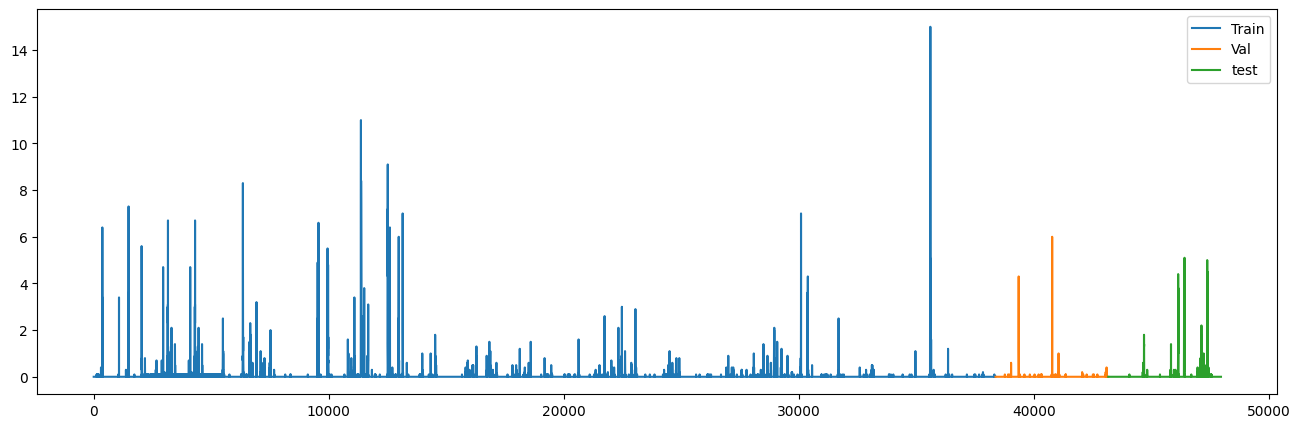

In [10]:
# Dibujar los subsets
from cProfile import label
import matplotlib.pyplot as plt


fig, ax =plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='test')
plt.legend()

In [11]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [13]:
import numpy as np
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 1440    # Registros de 24 horas consecutivas a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 1 hora a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (36920, 1440, 1), y_tr: (36920, 1, 1)
Set de validación - x_vl: (3354, 1440, 1), y_vl: (3354, 1, 1)
Set de prueba - x_ts: (3355, 1440, 1), y_ts: (3355, 1, 1)


## Escalamiento de los datos

In [14]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [15]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

data_s, scaler = escalar_dataset(data_in)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificacion
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento: 0.0/0.0/0.0
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-1.0/-1.0

Min y_tr/y_vl/y_ts sin escalamiento: 0.0/0.0/0.0
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-1.0/-1.0

Max x_tr/x_vl/x_ts sin escalamiento: 15.0/6.0/5.1
Max x_tr/x_vl/x_ts con escalamiento: 1.0/-0.19999999999999996/-0.32000000000000006

Max y_tr/y_vl/y_ts sin escalamiento: 15.0/6.0/5.1
Max y_tr/y_vl/y_ts con escalamiento: 1.0/-0.19999999999999996/-0.32000000000000006


## Creación y entrenamiento de la Red LSTM

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))

def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

#   COMPILACION

optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Entrenamiento del modelo

In [17]:
EPOCHS = 80
BATCH_SIZE = 256
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)


Epoch 1/80
145/145 - 18s - 122ms/step - loss: 0.3099 - val_loss: 0.0251
Epoch 2/80
145/145 - 15s - 107ms/step - loss: 0.0366 - val_loss: 0.0246
Epoch 3/80
145/145 - 21s - 143ms/step - loss: 0.0362 - val_loss: 0.0243
Epoch 4/80
145/145 - 16s - 111ms/step - loss: 0.0358 - val_loss: 0.0242
Epoch 5/80
145/145 - 21s - 142ms/step - loss: 0.0355 - val_loss: 0.0245
Epoch 6/80
145/145 - 16s - 113ms/step - loss: 0.0352 - val_loss: 0.0248
Epoch 7/80
145/145 - 21s - 144ms/step - loss: 0.0349 - val_loss: 0.0232
Epoch 8/80
145/145 - 20s - 140ms/step - loss: 0.0346 - val_loss: 0.0209
Epoch 9/80
145/145 - 20s - 140ms/step - loss: 0.0344 - val_loss: 0.0257
Epoch 10/80
145/145 - 20s - 141ms/step - loss: 0.0341 - val_loss: 0.0248
Epoch 11/80
145/145 - 21s - 142ms/step - loss: 0.0339 - val_loss: 0.0221
Epoch 12/80
145/145 - 17s - 114ms/step - loss: 0.0337 - val_loss: 0.0209
Epoch 13/80
145/145 - 20s - 140ms/step - loss: 0.0334 - val_loss: 0.0203
Epoch 14/80
145/145 - 16s - 113ms/step - loss: 0.0332 - val_

# graficar las perdidas

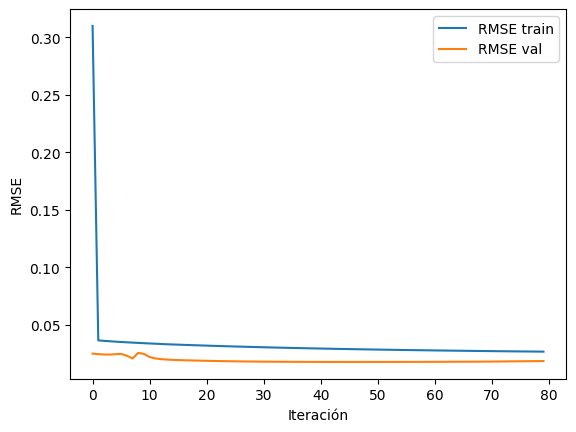

In [24]:
plt.plot(historia.history['loss'], label='RMSE train')
plt.plot(historia.history['val_loss'], label='RMSE val')  # Corregido 'lable' a 'label'
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend()
plt.show()


## Desempeño del modelo entrenado
Suponiendo que los hiperparámetros del modelo ya han sido afinados y que ya hemos realizado el entrenamiento con estos hiperparámetros, el siguiente paso es verificar su desempeño usando el set de datos que hasta el momento no hemos presentado a la Red: el set de prueba.

Podemos entonces calcular el desempeño del modelo obtenido para el set de prueba y compararlo con el desempeño obtenido con los sets de entrenamiento y validación.

Para ello podemos simplemente calcular el RMSE con cada subset usando el método evaluate, que permite tomar el modelo entrenado, generar las predicciones para cada subset y calcular el RMSE correspondiente:

In [18]:
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.020
  RMSE val:	 0.016
  RMSE test:	 0.022


## Predicciones (forecasting) con el modelo entrenado
Bien, teniendo claro que el modelo generaliza bastante bien, lo único que nos resta es ponerlo a prueba generando predicciones.

La idea en este caso es tomar los datos de prueba (registros continuos de 24 horas en cada ejemplo de prueba), presentarlos al modelo y obtener predicciones 1 hora a futuro de la temperatura.

Para ello implementaremos la función predecir, que tomará como entradas:

Uno o múltiples registros de 24 horas de temperatura escalados en el rango de -1 a 1 (variable x)
El modelo entrenado (variable model)
Y el escalador (variable scaler) requerido para realizar el escalamiento inverso de la predicción generada por el modelo
En primer lugar usaremos el método predict para generar con el modelo entrenado las predicciones escaladas (en el rango de -1 a 1). El resultado de esta predicción será almacenado en la variable y_pred_s.

A continuación tomaremos dichas predicciones escaladas y realizaremos la transformación inversa usando el método inverse_transform del escalador, con lo cual tendremos las predicciones en los niveles reales de temperatura.

La implementación completa de la función es entonces la siguiente:

In [19]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

En donde en la última línea hemos usado el método flatten para garantizar que las predicciones son un arreglo unidimensional de NumPy.

Ahora sólo nos resta llamar la función predecir para obtener cada una de las predicciones sobre el set de prueba:

In [20]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

Para analizar el comportamiento de estas predicciones (5.023 en total, una por cada dato de prueba) podemos simplemente generar una gráfica con las diferencias entre cada par de temperaturas reales y predichas:

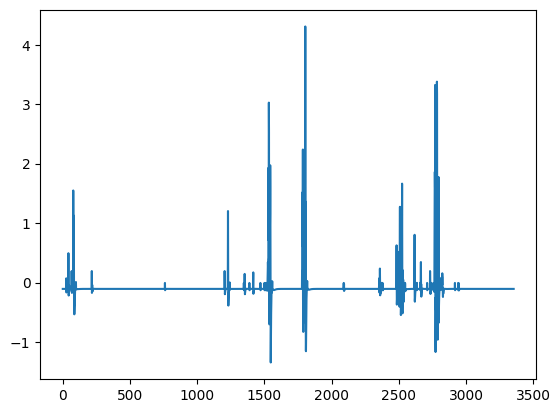

In [21]:
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

Al generar esta gráfica podemos verificar que en promedio los errores están alrededor de 0°C, lo cual quiere decir que en promedio las temperaturas predichas por el modelo se acercan bastante a los valores reales.

Sin embargo en algunos casos particulares los errores pueden llegar a ser de -7 °C del lado negativo y de +4 °C del lado positivo.

De nuevo, se podría intentar mejorar este aspecto del desempeño afinando los hiperparámetros del modelo.